<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/u2netp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U<sup>2</sup>-Net (U-Square Net)による背景分離

<center><img src="https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/u2netp-1.png?raw=1" alt="image" width=50%></center>

<center>左から入力画像、真値、U<sup>2</sup>-Netによる推論結果<sup>1</sup></center>

## U<sup>2</sup>-Netとは
U<sup>2</sup>-Netは、2020年にPattern Recognitionで発表された論文において提唱されたモデルです。主な用途として、画像中の主要なオブジェクト（salient object）の検出が挙げられます。公式レポジトリ<sup>2</sup>はApache 2.0ライセンスで公開されており、このモデルを使用して、U2-Netを基にした多くの興味深いアプリケーションやツールが開発されています。

今回は、そのうちの１つであるrembg<sup>3</sup>を紹介します。公式実装のpytorchモデルをonnxに変換し、pipでインストール可能なパッケージとして配布しされています。なお、rembg自体にはMITライセンスが付与されています。

### インストール・必要なライブラリのインポート

In [ ]:
# !pip install rembg  # cpu動作版
! pip install rembg[gpu]  # gpu　動作版

In [11]:
import cv2
from rembg import remove
from IPython.display import Image, display

In [13]:
# jupyter notebookで画像を表示させる
def show_image(img):
    _, img = cv2.imencode(".jpg",img)
    display(Image(data=img))

In [16]:
remove

<function rembg.bg.remove(data: Union[bytes, PIL.Image.Image, numpy.ndarray], alpha_matting: bool = False, alpha_matting_foreground_threshold: int = 240, alpha_matting_background_threshold: int = 10, alpha_matting_erode_size: int = 10, session: Optional[rembg.sessions.base.BaseSession] = None, only_mask: bool = False, post_process_mask: bool = False, bgcolor: Optional[Tuple[int, int, int, int]] = None, *args: Optional[Any], **kwargs: Optional[Any]) -> Union[bytes, PIL.Image.Image, numpy.ndarray]>

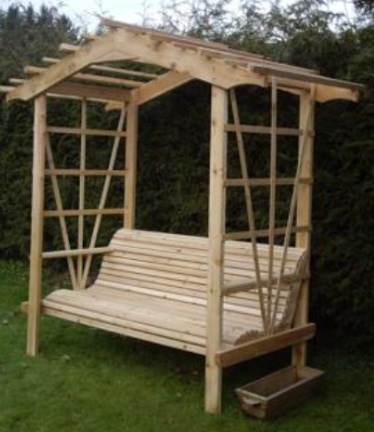

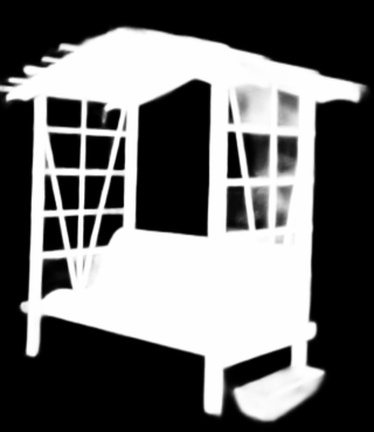

CPU times: user 3.44 s, sys: 305 ms, total: 3.75 s
Wall time: 1.31 s


In [18]:
%%time  
# 処理時間計測コマンド


input_path = '/content/スクリーンショット 2023-06-10 9.04.47.png'

image = cv2.imread(input_path)
mask = remove(image, only_mask=True)


# jupyter notebookで画像をセルに表示させる。matplotlibを使用してもよい。
show_image(image)
show_image(mask)

引用

<sup>1</sup>U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection, Qin et al., Pattern Recognition 2022.

<sup>2</sup>https://github.com/xuebinqin/U-2-Net

<sup>3</sup>https://github.com/danielgatis/rembg
